# Centrality Measures

In [187]:
import pathlib

import jupedsim as jps
import matplotlib.pyplot as plt
import pedpy
import shapely
import sqlite3
from matplotlib.patches import Circle
from shapely import Polygon
import networkx as nx
from jupedsim.internal.notebook_utils import animate, read_sqlite_file
%matplotlib inline
import plotly.graph_objects as go
from Py.centralityMeasures import centralityMeasuresAlgorithm
from Py.RiskSimulationValues import RiskSimulationValues

from Py.DangerSimulation import *
from Py.animation import animate

try:
    %reload_ext autoreload
except:
    %load_ext autoreload
%autoreload 2

Text(2.5, 2.5, 'Start')

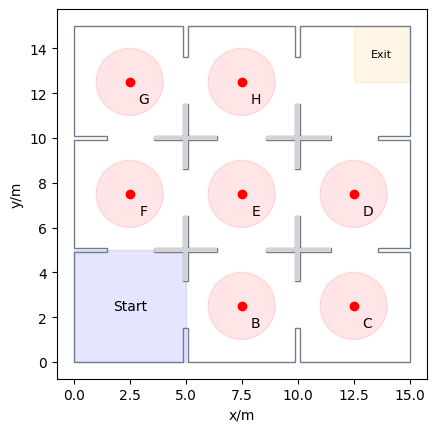

In [188]:
complete_area = Polygon(
    [
        (0, 0),
        (0, 15),
        (15, 15),
        (15, 0),
    ]
)
obstacles = [
    #bottom
    Polygon([(4.9, 0.0), (4.9, 1.5), (5.1, 1.5),(5.1, 0.0)]),
    Polygon([(9.9, 0.0), (9.9, 1.5), (10.1, 1.5),(10.1, 0.0)]),
    #right
    Polygon([(13.6, 4.9), (15, 4.9), (15, 5.1),(13.6, 5.1)]),
    Polygon([(13.6, 9.9), (15, 9.9), (15, 10.1),(13.6, 10.1)]),
    #top
    Polygon([(4.9, 15), (4.9, 13.6), (5.1, 13.6),(5.1, 15)]),
    Polygon([(9.9, 15), (9.9, 13.6), (10.1, 13.6),(10.1, 15)]),
    #left
    Polygon([(1.5, 4.9), (0, 4.9), (0, 5.1),(1.5, 5.1)]),
    Polygon([(1.5, 9.9), (0, 9.9), (0, 10.1),(1.5, 10.1)]),
    #center
    ## bottom left
    Polygon([(3.6, 4.9), (4.9, 4.9), (4.9, 3.6), (5.1, 3.6), (5.1, 4.9), (6.4, 4.9), (6.4, 5.1), (5.1, 5.1), (5.1, 6.5), (4.9, 6.5), (4.9, 5.1), (3.6, 5.1)  ]),
    ## bottom right
    Polygon([(8.6, 4.9), (9.9, 4.9), (9.9, 3.6), (10.1, 3.6), (10.1, 4.9), (11.5, 4.9), (11.5, 5.1), (10.1, 5.1), (10.1, 6.5), (9.9, 6.5), (9.9, 5.1), (8.6, 5.1)  ]),
    ## top left
    Polygon([(3.6, 9.9), (4.9, 9.9), (4.9, 8.6), (5.1, 8.6), (5.1, 9.9), (6.4, 9.9), (6.4, 10.1), (5.1, 10.1), (5.1, 11.5), (4.9, 11.5), (4.9, 10.1), (3.6, 10.1)  ]),
    ## top right
    Polygon([(8.6, 9.9), (9.9, 9.9), (9.9, 8.6), (10.1, 8.6), (10.1, 9.9), (11.5, 9.9), (11.5, 10.1), (10.1, 10.1), (10.1, 11.5), (9.9, 11.5), (9.9, 10.1), (8.6, 10.1)  ]),

]

exit_polygon = [(12.5, 12.5), (15, 12.5), (15, 15), (12.5, 15)]
waypoints = {'B':([7.5, 2.5], 1.5), 'C':([12.5, 2.5], 1.5), 'D':([12.5, 7.5], 1.5), 'E':([7.5, 7.5], 1.5), 'F':([2.5, 7.5], 1.5), 'G':([2.5, 12.5], 1.5), 'H':([7.5, 12.5], 1.5)}
distribution_polygon = Polygon([[0, 0], [5, 0], [5, 5], [0, 5]])
obstacle = shapely.union_all(obstacles)  # combines obstacle polygons into only one polygon
walkable_area = pedpy.WalkableArea(
    shapely.difference(complete_area, obstacle))  # difference subtracts obstacle form complete_area
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.set_aspect("equal")
pedpy.plot_walkable_area(walkable_area=walkable_area, axes=ax)

for idx, (waypoint, distance) in waypoints.items():
    ax.plot(waypoint[0], waypoint[1], "ro")
    ax.annotate(
        f"{idx}",
        (waypoint[0], waypoint[1]),
        textcoords="offset points",
        xytext=(10, -15),
        ha="center",
    )
    circle = Circle(
        (waypoint[0], waypoint[1]), distance, fc="red", ec="red", alpha=0.1
    )
    ax.add_patch(circle)

x, y = Polygon(exit_polygon).exterior.xy
plt.fill(x, y, alpha=0.1, color="orange")
centroid = Polygon(exit_polygon).centroid
plt.text(centroid.x, centroid.y, "Exit", ha="center", va="center", fontsize=8)

x, y = distribution_polygon.exterior.xy
plt.fill(x, y, alpha=0.1, color="blue")
centroid = distribution_polygon.centroid
plt.text(centroid.x, centroid.y, "Start", ha="center", va="center", fontsize=10)

In [189]:
def remove_obstacles_from_areas(specific_areas, obstacles):
    """
    Removes obstacles from specific areas by subtracting overlapping polygons.

    Args:
        specific_areas (dict): Dictionary of named areas {name: Polygon}.
        obstacles (list): List of Polygon objects representing obstacles.

    Returns:
        dict: Dictionary of cleaned areas {name: Polygon without obstacles}.
    """
    cleaned_areas = {}

    for name, area in specific_areas.items():
        # Subtract all obstacles from the current area
        cleaned_area = area
        for obstacle in obstacles:
            if cleaned_area.intersects(obstacle):  # Only process if they overlap
                cleaned_area = cleaned_area.difference(obstacle)

        # Store the cleaned area in the dictionary
        cleaned_areas[name] = cleaned_area

    return cleaned_areas

In [190]:
specific_areas = dict()
specific_areas['A'] = Polygon([(0,0), (5,0), (5,5), (0,5)])
specific_areas['B'] = Polygon([(5,0), (10,0), (10,5), (5,5)])
specific_areas['C'] = Polygon([(10,0), (15,0), (15,5), (10,5)])
specific_areas['D'] = Polygon([(10,5), (15,5), (15,10), (10,10)])
specific_areas['E'] = Polygon([(5,5), (10,5), (10,10), (5,10)])
specific_areas['F'] = Polygon([(0,5), (5,5), (5,10), (0,10)])
specific_areas['G'] = Polygon([(0,10), (5,10), (5,15), (0,15)])
specific_areas['H'] = Polygon([(5,10), (10,10), (10,15), (5,15)])
specific_areas['I'] = Polygon([(10,10), (15,10), (15,15), (10,15)])

In [191]:
specific_areas = remove_obstacles_from_areas(specific_areas, obstacles)

## Configuration of Simulation Scenarios

In [192]:
simulations = {}
percentages = [0]
total_agents = 10
for percentage in percentages:
    trajectory_file = f"../../sqlite_data/centrality_measures_percentage_{percentage}.sqlite"
    simulation = jps.Simulation(
        #dt=0.005,
        model=jps.CollisionFreeSpeedModel(
            strength_neighbor_repulsion=2.6,
            range_neighbor_repulsion=0.1,
            range_geometry_repulsion=0.05,
        ),
        geometry=walkable_area.polygon,
        trajectory_writer=jps.SqliteTrajectoryWriter(
            output_file=pathlib.Path(trajectory_file),
        ),
    )
    simulations[percentage] = simulation

## Choosing the path


In [193]:
# Create the graph
G = nx.DiGraph()

# Nodos y sus niveles iniciales de riesgo (0 a 1)
nodes = {
    "A": 0.0, "B": 0.6, "C": 0.0,
    "D": 0.6, "E": 0.6, "F": 0.1,
    "G": 0.0, "H": 0.0, "I": 0.0,
}

# Agregar nodos al grafo
for node, risk in nodes.items():
    G.add_node(node, risk=risk)

# Definir las conexiones entre nodos
edges = [
    ("A", "B"), ("A", "F"), ("B", "A"), ("B", "E"), ("B", "C"),
    ("C", "B"), ("C", "D"), ("D", "I"), ("D", "E"), ("D", "C"),
    ("E", "D"), ("E", "F"), ("E", "B"), ("E", "H"), ("F", "A"),
    ("F", "E"), ("F", "G"), ("G", "F"), ("G", "H"), ("H", "E"),
    ("H", "G"), ("H", "I"),
]

# Agregar las aristas con un costo fijo (se puede ajustar)
G.add_edges_from([(u, v, {"cost": 3}) for u, v in edges])

# Parameters for calculation
sources = ["A"]  # Source nodes
targets = ["I"]  # Target nodes

# Calculate all efficient paths between source-target pairs
gamma = 0.2  # Time tolerance factor

_, _, possible_paths = centralityMeasuresAlgorithm(G, sources, targets, gamma)

## Outlining Agent Journeys

In [194]:
def differentGraphs(start, end, paths, waypoint_ids, exit_id):
    """
    Creates journey descriptions for agents based on paths ordered by centrality scores.

    Args:
        start (str): Starting node in the graph.
        end (str): Ending node in the graph.
        paths (dict): Dictionary of paths ordered by centrality scores.
                      Structure: {source: [(path1, score1), (path2, score2), ...], ...}
        waypoint_ids (dict): Dictionary mapping node IDs to waypoint IDs in the simulation.
        exit_id (int): ID of the exit stage in the simulation.

    Returns:
        list[jps.JourneyDescription]: List of journey descriptions for the agents.
    """
    if not paths:
        raise ValueError(f"No valid paths found from {start} to {end}.")

    journeys = []
    for source, path_list in paths.items():
        for path, score in path_list:  # Unpack path and its centrality score
            if len(path) < 2:
                continue

            # Map graph nodes in the path to waypoint IDs, excluding start and end nodes
            needed_waypoints = [waypoint_ids[node] for node in path[1:-1]]
            if not needed_waypoints:
                continue

            # Create the journey description
            journey = jps.JourneyDescription([*needed_waypoints, exit_id])

            # Set transitions between waypoints
            for idx, waypoint in enumerate(needed_waypoints):
                next_waypoint = exit_id if idx == len(needed_waypoints) - 1 else needed_waypoints[idx + 1]
                journey.set_transition_for_stage(
                    waypoint, jps.Transition.create_fixed_transition(next_waypoint)
                )

            journeys.append((journey, path))

    return journeys

In [195]:
def set_journeys(simulation, start, end, paths):
    """
    Configures agent journeys in the simulation.

    Args:
        simulation (jps.Simulation): The simulation instance.
        start (str): Starting node in the graph.
        end (str): Ending node in the graph.

    Returns:
        tuple: Journeys IDs and the dictionary of waypoint IDs.
    """
    # Add the exit stage to the simulation
    exit_id = simulation.add_exit_stage(exit_polygon)

    # Map nodes to waypoint IDs
    waypoint_ids = {}
    for node, (waypoint, distance) in waypoints.items():
        waypoint_ids[node] = simulation.add_waypoint_stage(waypoint, distance)

    # Create the journey based on the best paths
    journeys = differentGraphs(start, end, paths, waypoint_ids, exit_id)

    journeys_id = dict()  # Initialize an empty dictionary to store journey IDs and their associated paths

    # Iterate over the journeys and their respective paths
    for journey, path in journeys:
        # Add each journey to the simulation and retrieve its unique ID
        journey_id = simulation.add_journey(journey)

        # Ensure the starting node is initialized in the dictionary
        if start not in journeys_id:
            journeys_id[start] = []

        # Store the journey ID and the path in journeys_id for the starting node (start)
        journeys_id[start].append((journey_id, path))

    return journeys_id, waypoint_ids

## Allocate Agents

In [196]:
positions = jps.distribute_by_number(
    polygon=distribution_polygon,
    number_of_agents=total_agents,
    distance_to_agents=0.4,
    distance_to_polygon=0.7,
    seed=45131502,
)

## Launching the Simulation

In [197]:
def simulate_risk_per_frame(
    G: nx.DiGraph,
    total_frames: int,
    propagation_chance=0.3,
    increase_chance=0.2,
):
    """
    Genera niveles de riesgo por frame para sincronizar con la simulación de agentes.

    Parámetros:
        G (nx.DiGraph): Grafo con áreas y conexiones.
        total_frames (int): Número total de frames de la simulación.
        propagation_chance (float): Probabilidad de propagar riesgo.
        increase_chance (float): Probabilidad de incrementar riesgo.

    Retorna:
        dict: Riesgos por frame en formato {frame: {area: riesgo}}.
    """
    risks_per_frame = {}

    for frame in range(total_frames):
        # Actualizar riesgos en el grafo
        update_risk(G, propagation_chance, increase_chance)

        # Guardar riesgos actuales
        risks_per_frame[frame] = {node: G.nodes[node]["risk"] for node in G.nodes}

    return risks_per_frame

In [198]:
def update_group_paths(simulation, risk_per_node, waypoint_id, journeys_id, agent_group, risk_threshold=0.5):
    """
    Updates the paths of a group of agents based on the current node of the first agent in the group.
    If the path is considered unsafe, all agents in the group are updated.

    Args:
        simulation (jps.Simulation): Instance of the simulation.
        G (networkx.DiGraph): Graph representing node connections and risks.
        waypoint_id (dict): Dictionary mapping nodes to waypoint IDs.
        journeys_id (dict): Dictionary mapping start nodes to a list of tuples (journey_id, path).
        agent_group (tuple): Tuple containing a list of agent IDs and the current path.
        risk_threshold (float): Risk threshold above which a path segment is considered unsafe.

    Returns:
        tuple: Updated agent_group tuple with the new path, or the original if no update was made.
    """

    agents_ids, current_path = agent_group
    if not agents_ids:
        # No agents in the group
        return agent_group

    # Get the ID of the agent in the middle of the group
    # first_agent_id = agents_ids[(len(agents_ids) // 2) - 1] !!!!!!!!!!!!!!!!!!!!11
    first_agent_id = agents_ids[0]
    # Check if the first agent still exists in the simulation
    agent_exists = any(agent.id == first_agent_id for agent in simulation.agents())
    if not agent_exists:
        # The first agent no longer exists in the simulation
        return agent_group

    # Retrieve the first agent to evaluate the group's path
    agent = simulation.agent(first_agent_id)

    current_stage = agent.stage_id  # Current stage ID of the agent
    next_node = None

    # Find the node associated with the agent's current stage
    for node, waypoint in waypoint_id.items():
        if waypoint == current_stage:
            next_node = node
            break

    # If the next node is not found, exit
    if not next_node:
        return agent_group

    # Get the current node the agent is heading to
    index = current_path.index(next_node) - 1
    current_node = current_path[index]

    # Check if the next node is dangerous
    if risk_per_node[next_node] < risk_threshold:
        # The next node is safe; no changes needed
        return agent_group

    # If the next node is dangerous, search for alternative paths that pass through the current node
    alternative_paths = []
    for journey_id, path in journeys_id.get("A", []):  # Assuming all paths start from "A" !!!!!!!!!!!!!!
        if current_node in path:
            # Get the segment of the path from the current node to the end
            start_index = path.index(current_node)
            remaining_path = path[start_index:]

            # Calculate the total risk of the remaining path
            total_risk = sum(risk_per_node[node] for node in remaining_path)

            # Add the path and its risk if it's below the threshold
            alternative_paths.append((journey_id, remaining_path, total_risk))

    if alternative_paths :
        # Select the best alternative path (lowest risk)
        best_path = min(alternative_paths, key=lambda x: x[2])  # Minimice total risk
        new_journey_id = best_path[0]
        remaining_path = best_path[1]

        # Determine the next node in the path
        if len(remaining_path) > 1:
            next_node = remaining_path[1]
            next_stage_id = waypoint_id[next_node]

            # Update all agents in the group to the new journey and stage
            for agent_id in agents_ids:
                simulation.switch_agent_journey(agent_id, new_journey_id, next_stage_id)

            # Return the updated agent_group tuple with the new path
            return (agents_ids, remaining_path)

    # If no update was made, return the original agent_group
    return agent_group

In [199]:
def simulate_risk(riskSimulationValues, every_nth_frame, G, connection):
    """
    Simulates risk propagation in a graph over multiple frames and stores the results in a database.

    Args:
        iterations (int): Total number of frames to simulate.
        every_nth_frame (int): Interval of frames at which risk updates are performed.
        G (networkx.Graph): Graph where each node has a "risk" attribute.
        propagation_chance (float): Probability of risk spreading between connected nodes.
        increase_chance (float): Probability of individual nodes increasing their risk.
        connection (sqlite3.Connection): Open SQLite database connection to store risk data.
    """
    # Validate the input arguments
    if riskSimulationValues.iterations <= 0:
        raise ValueError("iterations must be a positive integer.")
    if every_nth_frame <= 0:
        raise ValueError("every_nth_frame must be a positive integer.")

    for frame in range(riskSimulationValues.iterations + 1):
        if frame == 0:
            # Save the initial risk levels of all nodes before any updates
            try:
                write_risk_levels(connection, 0, {node: G.nodes[node]["risk"] for node in G.nodes})
            except Exception as e:
                print(f"Error writing initial risks: {e}")
            continue

        if frame % every_nth_frame == 0:
            try:
                # Update risks in the graph based on propagation and increase chances
                update_risk(G, riskSimulationValues.propagation_chance, riskSimulationValues.increase_chance)
                # Save the updated risk levels for the current frame
                write_risk_levels(connection, frame, {node: G.nodes[node]["risk"] for node in G.nodes})
            except Exception as e:
                print(f"Error updating risks at frame {frame}: {e}")

In [200]:
def run_agent_simulation(simulation, connection, every_nth_frame, waypoint_id, journeys_id, agent_group, risk_threshold):
    """
    Runs the agent simulation, updating their paths based on risk levels from the database.

    Args:
        simulation (object): Jupedsim simulation object managing agents and environment.
        connection (sqlite3.Connection): Open SQLite database connection to fetch risk data.
        every_nth_frame (int): Interval at which agent paths are updated.
        waypoint_id (dict): Mapping of nodes to waypoint IDs.
        journeys_id (dict): Mapping of source nodes to journey IDs.
        agent_group (tuple): Tuple containing agents and their current path.
        risk_threshold (float): Threshold above which agents will try to avoid high-risk areas.
    """
    while simulation.agent_count() > 0:
        # Advance the simulation by one frame
        simulation.iterate()
        frame = simulation.iteration_count()

        # Update agent paths only at specified intervals
        if frame % every_nth_frame == 0:
            try:
                # Fetch risk levels for the current frame from the database
                risk_this_frame = get_risk_levels_by_frame(connection, frame)

                # Update paths for the agents based on current risks and threshold
                agent_group = update_group_paths(
                    simulation, risk_this_frame, waypoint_id, journeys_id, agent_group, risk_threshold=risk_threshold
                )
            except Exception as e:
                print(f"Error updating paths at frame {frame}: {e}")

In [201]:
# False -> to use the default risk evolution, True -> random risk evolution
use_random_risk_layout = True

In [184]:
trajectory_files = {}
for percentage, simulation in simulations.items():
    # Set up journeys and waypoints for the simulation
    journeys_id, waypoint_id = set_journeys(
        simulation, sources[0], targets[0], possible_paths  # sources[0] -> start, targets[0] -> exit
    )

    # Retrieve the best path for the first source and its associated journey ID
    journey_id, best_path_source_0 = journeys_id[sources[0]][0]
    next_node = best_path_source_0[1]  # Get the next node on the best path
    first_waypoint_id = waypoint_id[next_node]  # Determine the waypoint ID for the next node

    # Calculate the number of items based on the percentage of positions
    num_items = int(len(positions) * (percentage / 100.0))

    # Initialize an agent group
    agents = []
    for position in positions[num_items:]:  # Use the second half of the positions
        # Add agents with specified parameters (e.g., position, journey, velocity)
        agents.append(
            simulation.add_agent(
                jps.CollisionFreeSpeedModelAgentParameters(
                    position=position,       # Initial position of the agent
                    journey_id=journey_id,   # Journey ID for the agent
                    stage_id=first_waypoint_id,  # Starting waypoint for the agent
                    v0=0.8                   # Desired maximum speed of the agent
                )
            )
        )
    agent_group = (agents, best_path_source_0)  # Group the agents with their best path

    # Simulation parameters
    every_nth_frame = 50  # Interval of frames for risk updates
    riskSimulationValues = RiskSimulationValues(3000, 0.005, 0.09)

    # Establish a connection to the appropriate SQLite database
    default_connection_file = "../../sqlite_data/default_centrality_measures_risks.db" # default risk evolution file
    new_connection_file = "../../sqlite_data/centrality_measures_risks.db" # random risk evolution file
    if use_random_risk_layout:
        connection_file = new_connection_file  # Use new database if random risk layout is enabled
    else:
        connection_file = default_connection_file  # Use default database otherwise

    connection = sqlite3.connect(connection_file)

    try:
        if use_random_risk_layout:
            # Create or reset the risk table if random risk layout is enabled
            create_risk_table(connection)

            # Simulate risk propagation and store results in the database
            simulate_risk(riskSimulationValues, every_nth_frame, G, connection)

        # Run the agent simulation, updating paths based on the risk levels
        run_agent_simulation(
            simulation,
            connection,
            every_nth_frame,
            waypoint_id,
            journeys_id,
            agent_group,
            risk_threshold=0.5  # Threshold for avoiding high-risk areas
        )
    finally:
        # Ensure the database connection is closed after operations
        connection.close()

    # Generate the trajectory file for the current percentage and store its path
    trajectory_file = f"../../sqlite_data/centrality_measures_percentage_{percentage}.sqlite"
    trajectory_files[percentage] = trajectory_file

In [185]:
# Open the database connection safely
with sqlite3.connect(connection_file) as connection:
    # Fetch all risk data grouped by frame
    all_risks = get_risks_grouped_by_frame(connection)

    # Iterate over the nested dictionary
    for frame, areas in all_risks.items():  # 'areas' is a dictionary {area: risk_level}
        for area, risk in areas.items():
            print(f"Frame {frame}, Area {area}: Risk Level {risk}")

# Connection automatically closes when 'with' block ends

Frame 0, Area A: Risk Level 0.0
Frame 0, Area B: Risk Level 0.6
Frame 0, Area C: Risk Level 0.0
Frame 0, Area D: Risk Level 0.6
Frame 0, Area E: Risk Level 0.6
Frame 0, Area F: Risk Level 0.1
Frame 0, Area G: Risk Level 0.0
Frame 0, Area H: Risk Level 0.0
Frame 0, Area I: Risk Level 0.0
Frame 50, Area A: Risk Level 0.0
Frame 50, Area B: Risk Level 0.6
Frame 50, Area C: Risk Level 0.0
Frame 50, Area D: Risk Level 0.6
Frame 50, Area E: Risk Level 0.6
Frame 50, Area F: Risk Level 0.1
Frame 50, Area G: Risk Level 0.0
Frame 50, Area H: Risk Level 0.0
Frame 50, Area I: Risk Level 0.0
Frame 100, Area A: Risk Level 0.0
Frame 100, Area B: Risk Level 0.8
Frame 100, Area C: Risk Level 0.0
Frame 100, Area D: Risk Level 0.6
Frame 100, Area E: Risk Level 0.6
Frame 100, Area F: Risk Level 0.1
Frame 100, Area G: Risk Level 0.2
Frame 100, Area H: Risk Level 0.0
Frame 100, Area I: Risk Level 0.0
Frame 150, Area A: Risk Level 0.0
Frame 150, Area B: Risk Level 1.0
Frame 150, Area C: Risk Level 0.0
Frame 1

## Visualizing Agent Pathways

In [186]:
agent_trajectories = {}
for percentage in percentages:
    trajectory_file = trajectory_files[percentage]
    agent_trajectories[percentage], walkable_area = read_sqlite_file(
        trajectory_file
    )
    animate(
        agent_trajectories[percentage],
        walkable_area,
        title_note=f"Percentage using the shortest path: {percentage}%",
        risk_per_frame=all_risks,
        specific_areas=specific_areas
    ).show()